In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import osmnx as ox
import re
import matplotlib.pyplot as plt

In [2]:
G_lu = pd.read_pickle("../Geo_Datasets/London_tube_network_cl.pkl")

In [3]:
print(G_lu.number_of_nodes())
print(G_lu.number_of_edges())

401
467


In [4]:
# To check node attributes:
list(G_lu.nodes(data = True))[0]

('Edgware', {'coords': (519497.64608500665, 191981.34593468817)})

In [5]:
# To check edges attributes:
list(G_lu.edges(data = True))[0]

('Edgware',
 'Burnt Oak',
 {'length': 1518.1144792538078, 'line_name': 'Northern'})

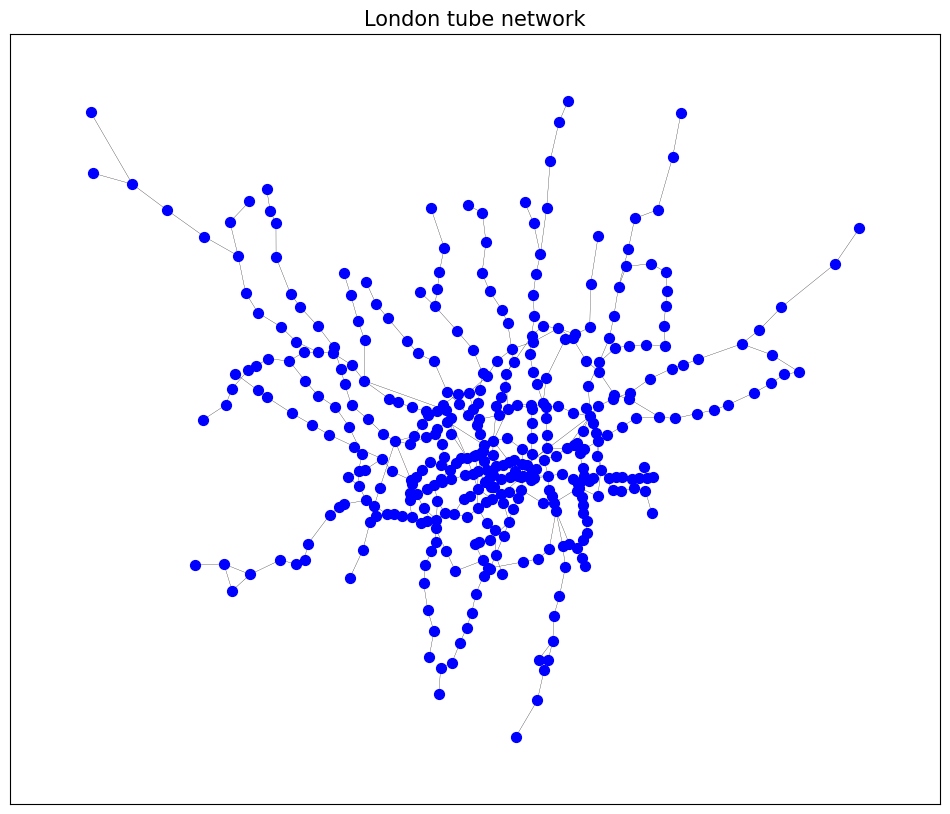

In [6]:
# plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(12,10))

node_labels = nx.get_node_attributes(G_lu, 'station_name')

pos = nx.get_node_attributes(G_lu, 'coords')

nx.draw_networkx_nodes(G_lu,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G_lu,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G_lu,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("on")
plt.show()

In [7]:
list(G_lu.nodes(data = True))[0]

('Edgware', {'coords': (519497.64608500665, 191981.34593468817)})

In [8]:
deg_london_t =nx.degree_centrality(G_lu)
nx.set_node_attributes(G_lu,dict(deg_london_t),'degree_t')

df_d_t = pd.DataFrame(index=G_lu.nodes())
df_d_t['station_name'] = df_d_t.index
df_d_t['degree_t'] = pd.Series(nx.get_node_attributes(G_lu, 'degree_t'))

df_d_t_sorted = df_d_t.sort_values(["degree_t"], ascending=False)
df_d_t_sorted.reset_index(drop=True, inplace=True)

df_d_t_sorted[0:10]

,station_name,degree_t
0,Stratford,0.0225
1,Bank and Monument,0.0200
2,Baker Street,0.0175
3,King's Cross St. Pancras,0.0175
4,Waterloo,0.0150
5,Earl's Court,0.0150
6,Canning Town,0.0150
7,Liverpool Street,0.0150
8,Oxford Circus,0.0150
9,West Ham,0.0150


In [9]:
bet_london_t=nx.betweenness_centrality(G_lu, normalized=False)
nx.set_node_attributes(G_lu,bet_london_t,'betweenness_t')

df_b_t = pd.DataFrame(index=G_lu.nodes())
df_b_t['station_name'] = df_b_t.index
df_b_t['betweenness_t'] = pd.Series(nx.get_node_attributes(G_lu, 'betweenness_t'))

df_b_t_sorted = df_b_t.sort_values(["betweenness_t"], ascending=False)
df_b_t_sorted.reset_index(drop=True, inplace=True)

df_b_t_sorted[0:10]

,station_name,betweenness_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
5,Green Park,17223.622114
6,Euston,16624.275469
7,Westminster,16226.155916
8,Baker Street,15287.107612
9,Finchley Road,13173.758009


In [10]:
clos_london_t=nx.closeness_centrality(G_lu)
nx.set_node_attributes(G_lu,clos_london_t,'closeness_t')

df_c_t = pd.DataFrame(index=G_lu.nodes())
df_c_t['station_name'] = df_c_t.index
df_c_t['closeness_t'] = pd.Series(nx.get_node_attributes(G_lu, 'closeness_t'))

df_c_t_sorted = df_c_t.sort_values(["closeness_t"], ascending=False)
df_c_t_sorted.reset_index(drop=True, inplace=True)

df_c_t_sorted[0:10]

,station_name,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
5,Oxford Circus,0.111204
6,Bond Street,0.110988
7,Angel,0.110742
8,Farringdon,0.110742
9,Moorgate,0.110314


In [11]:
G_lu_d=G_lu.copy()
G_lu_b=G_lu.copy()
G_lu_c=G_lu.copy()

In [12]:
def analyze_resilience(G, centrality_type, num_removals=10):
    """
    Analyze network resilience by sequentially removing the highest-ranked node 
    based on the selected centrality measure and tracking the Largest Connected Component (LCC).

    :param G: NetworkX graph object
    :param centrality_type: Type of centrality ('degree', 'betweenness', 'closeness')
    :param num_removals: Number of nodes to remove (default: 10)
    :return: List of LCC sizes after each removal
    """

    # copy graph to avoid modifying the original
    G = G.copy()
    lcc_sizes = []  # store LCC sizes after each step

    # mapping of centrality functions
    centrality_functions = {
        'degree': nx.degree_centrality,
        'betweenness': nx.betweenness_centrality,
        'closeness': nx.closeness_centrality
    }

    # ensure the chosen centrality type is valid
    if centrality_type not in centrality_functions:
        raise ValueError("Centrality type must be 'degree', 'betweenness', or 'closeness'")

    for i in range(num_removals):
        # compute centrality scores
        centrality = centrality_functions[centrality_type](G)

        # identify the node with the highest centrality score
        node_to_remove = max(centrality, key=centrality.get)

        # remove the selected node from the graph
        G.remove_node(node_to_remove)

        # compute the Largest Connected Component (LCC)
        largest_cc = max(nx.connected_components(G), key=len) if G.number_of_nodes() > 0 else set()
        lcc_size = len(largest_cc)
        lcc_sizes.append(lcc_size)

        print(f"Step {i+1}: Removed {node_to_remove}, LCC size: {lcc_size}")

    # plotting LCC size over node removals
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_removals + 1), lcc_sizes, marker='o', linestyle='-')
    plt.title(f'LCC Size vs. Node Removals ({centrality_type.capitalize()} Centrality)')
    plt.xlabel('Number of Nodes Removed')
    plt.ylabel('Size of Largest Connected Component (LCC)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Resilience analysis complete.")

    return lcc_sizes

Step 1: Removed Stratford, LCC size: 379
Step 2: Removed Bank and Monument, LCC size: 378
Step 3: Removed King's Cross St. Pancras, LCC size: 377
Step 4: Removed Baker Street, LCC size: 374
Step 5: Removed Oxford Circus, LCC size: 372
Step 6: Removed Canning Town, LCC size: 358
Step 7: Removed Earl's Court, LCC size: 357
Step 8: Removed Waterloo, LCC size: 356
Step 9: Removed Willesden Junction, LCC size: 342
Step 10: Removed Green Park, LCC size: 341


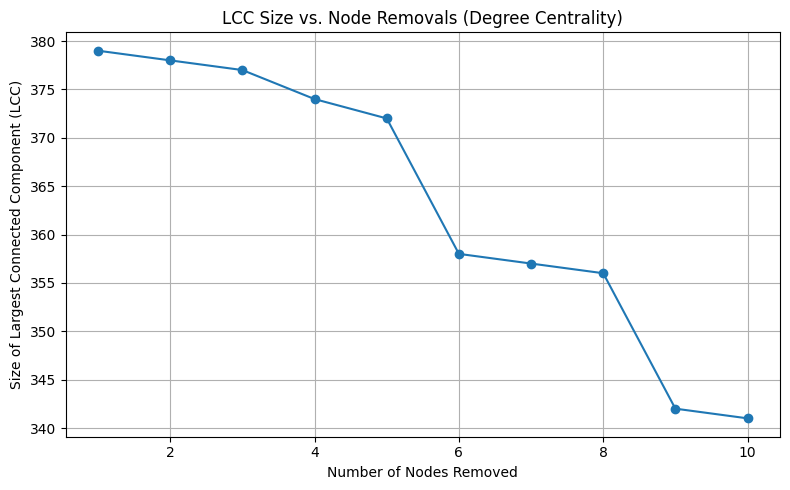

Resilience analysis complete.


In [13]:
lcc_degree = analyze_resilience(G_lu_d, 'degree')

Step 1: Removed Stratford, LCC size: 379
Step 2: Removed King's Cross St. Pancras, LCC size: 378
Step 3: Removed Waterloo, LCC size: 377
Step 4: Removed Bank and Monument, LCC size: 376
Step 5: Removed Canada Water, LCC size: 375
Step 6: Removed West Hampstead, LCC size: 227
Step 7: Removed Earl's Court, LCC size: 226
Step 8: Removed Shepherd's Bush, LCC size: 196
Step 9: Removed Euston, LCC size: 173
Step 10: Removed Baker Street, LCC size: 170


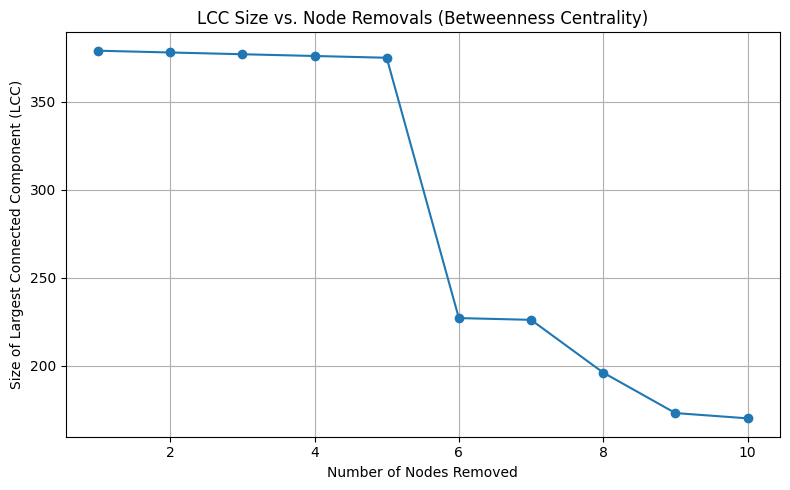

Resilience analysis complete.


In [14]:
lcc_betweenness = analyze_resilience(G_lu_b, 'betweenness')

Step 1: Removed Green Park, LCC size: 400
Step 2: Removed King's Cross St. Pancras, LCC size: 399
Step 3: Removed Waterloo, LCC size: 398
Step 4: Removed Bank and Monument, LCC size: 397
Step 5: Removed West Hampstead, LCC size: 396
Step 6: Removed Canada Water, LCC size: 226
Step 7: Removed Stratford, LCC size: 226
Step 8: Removed Earl's Court, LCC size: 225
Step 9: Removed Shepherd's Bush, LCC size: 195
Step 10: Removed Oxford Circus, LCC size: 194


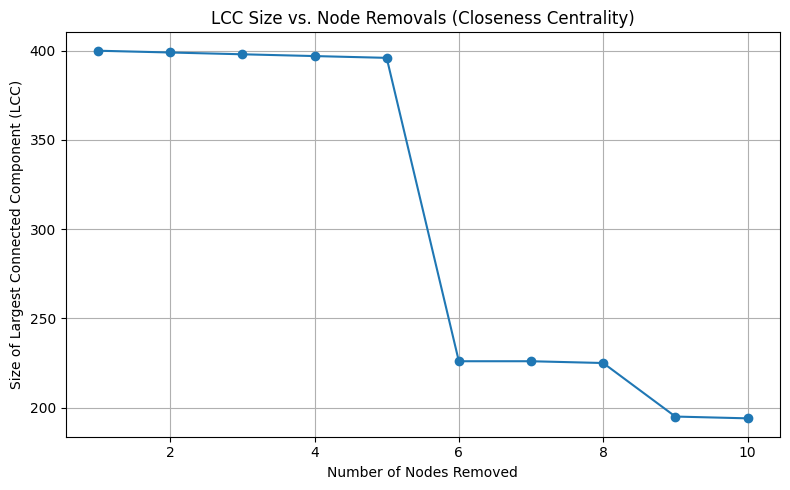

Resilience analysis complete.


In [15]:
lcc_closeness = analyze_resilience(G_lu_c, 'closeness')

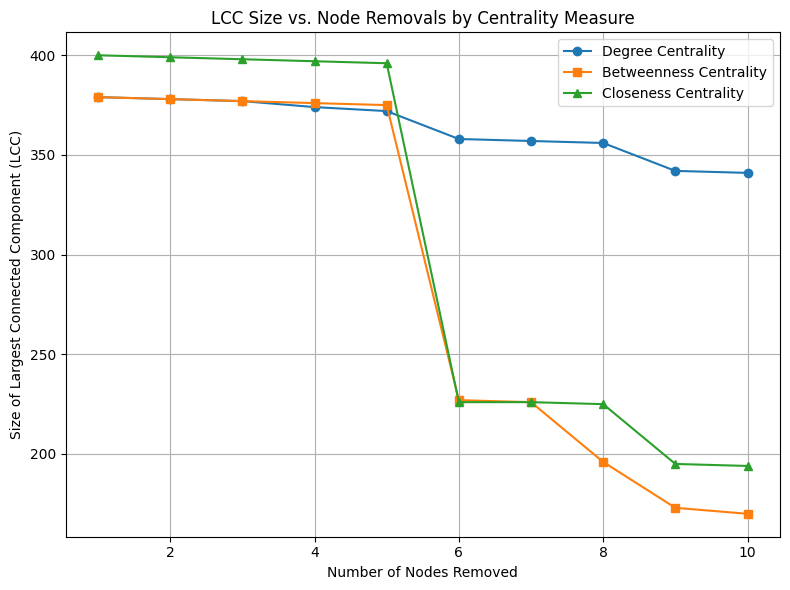

In [16]:
x = list(range(1, len(lcc_degree) + 1))

plt.figure(figsize=(8, 6))

plt.plot(x, lcc_degree, marker='o', label='Degree Centrality')
plt.plot(x, lcc_betweenness, marker='s', label='Betweenness Centrality')
plt.plot(x, lcc_closeness, marker='^', label='Closeness Centrality')

plt.title('LCC Size vs. Node Removals by Centrality Measure')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Size of Largest Connected Component (LCC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# tlf provides passenger flow data for each network separately
# create a list of all the different files we need
files = ['../Datasets/NBT19MTT2b_od__DLR_tb_wf.csv', 
         '../Datasets/NBT19MTT2b_od__EZL_tb_wf.csv', 
         '../Datasets/NBT19MTT2b_od__LO_tb_wf.csv', 
         '../Datasets/NBT19MTT2b_od__LU_tb_wf.csv']

# create an empty list to store dataframes for each file
dfs = []

# iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv(file))
    
# merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [18]:
london_OD.rename({'1':'Early(3-5)'}, axis=1, inplace=True)
london_OD.rename({'2':'Morning(5-7)'}, axis=1, inplace=True)
london_OD.rename({'3':'AMPeak(7-10)'}, axis=1, inplace=True)
london_OD.rename({'4':'InterPeak(10-16)'}, axis=1, inplace=True)
london_OD.rename({'5':'PMPeak(16-19)'}, axis=1, inplace=True)
london_OD.rename({'6':'Evening(19-22)'}, axis=1, inplace=True)
london_OD.rename({'7':'Late(22-0.5)'}, axis=1, inplace=True)
london_OD.rename({'8':'Night(0.5-3)'}, axis=1, inplace=True)

In [19]:
definition_df = pd.read_excel('../Datasets/NBT19_Definitions.xlsx', 'Stations')
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500.0,ACTu,Acton Town,True
1,501.0,BARu,Barbican,True
2,502.0,ALDu,Aldgate,True
3,503.0,ALEu,Aldgate East,True
4,504.0,STId,Stratford International DLR,True


In [20]:
# drop any missing values from our dataframe
definition_df.dropna(inplace=True)

# transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)

In [21]:
# add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])

In [22]:
london_OD

,mode_mnlc_o,mode_mnlc_d,Morning(5-7),AMPeak(7-10),InterPeak(10-16),PMPeak(16-19),Evening(19-22),Late(22-0.5),mode,Early(3-5),Night(0.5-3),station_origin,station_destination
0,504,523,8.03300,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN,Stratford International DLR,King George V
1,504,533,30.71900,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN,Stratford International DLR,London City Airport
2,504,538,5.94100,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN,Stratford International DLR,Pontoon Dock
3,504,559,5.79500,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN,Stratford International DLR,West Silvertown
4,504,573,77.78600,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN,Stratford International DLR,Woolwich Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,884,784,97.99600,538.180,298.849,173.856,51.263,14.653,LU,0.0,0.0,Canning Town,Southwark
62576,884,787,115.91900,281.952,149.409,138.607,64.885,25.433,LU,0.0,0.0,Canning Town,Bermondsey
62577,884,788,139.04400,682.340,768.051,504.189,345.944,113.663,LU,0.0,0.0,Canning Town,Canada Water
62578,884,789,156.23601,481.302,702.600,595.686,317.113,63.273,LU,0.0,0.0,Canning Town,North Greenwich


In [23]:
london_OD_sum = london_OD.fillna(0)

In [24]:
london_OD_sum

,mode_mnlc_o,mode_mnlc_d,Morning(5-7),AMPeak(7-10),InterPeak(10-16),PMPeak(16-19),Evening(19-22),Late(22-0.5),mode,Early(3-5),Night(0.5-3),station_origin,station_destination
0,504,523,8.03300,16.430,24.563,28.555,13.023,2.263,DLR,0.0,0.0,Stratford International DLR,King George V
1,504,533,30.71900,40.105,61.571,57.881,15.573,0.317,DLR,0.0,0.0,Stratford International DLR,London City Airport
2,504,538,5.94100,17.238,37.493,43.158,33.890,10.429,DLR,0.0,0.0,Stratford International DLR,Pontoon Dock
3,504,559,5.79500,26.397,27.285,24.065,15.213,8.508,DLR,0.0,0.0,Stratford International DLR,West Silvertown
4,504,573,77.78600,113.750,143.938,387.562,165.776,65.283,DLR,0.0,0.0,Stratford International DLR,Woolwich Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62575,884,784,97.99600,538.180,298.849,173.856,51.263,14.653,LU,0.0,0.0,Canning Town,Southwark
62576,884,787,115.91900,281.952,149.409,138.607,64.885,25.433,LU,0.0,0.0,Canning Town,Bermondsey
62577,884,788,139.04400,682.340,768.051,504.189,345.944,113.663,LU,0.0,0.0,Canning Town,Canada Water
62578,884,789,156.23601,481.302,702.600,595.686,317.113,63.273,LU,0.0,0.0,Canning Town,North Greenwich


In [25]:
timeband = ['Early(3-5)', 'Morning(5-7)', 'AMPeak(7-10)', 'InterPeak(10-16)', 'PMPeak(16-19)', 'Evening(19-22)', 'Late(22-0.5)', 'Night(0.5-3)']
mode_mnlc = ['mode_mnlc_o',	'mode_mnlc_d']

london_OD_sum['Flow_Sum'] = london_OD_sum[timeband].sum(axis=1)
london_OD_sum.Flow_Sum = london_OD_sum.Flow_Sum.astype(int)

london_OD_sum.drop(columns = timeband, axis=1, inplace=True)
london_OD_sum.drop(columns = mode_mnlc, axis=1, inplace=True)

In [26]:
london_OD_sum

,mode,station_origin,station_destination,Flow_Sum
0,DLR,Stratford International DLR,King George V,92
1,DLR,Stratford International DLR,London City Airport,206
2,DLR,Stratford International DLR,Pontoon Dock,148
3,DLR,Stratford International DLR,West Silvertown,107
4,DLR,Stratford International DLR,Woolwich Arsenal,954
...,...,...,...,...
62575,LU,Canning Town,Southwark,1174
62576,LU,Canning Town,Bermondsey,776
62577,LU,Canning Town,Canada Water,2553
62578,LU,Canning Town,North Greenwich,2316


In [27]:
station_origin_overall = list(london_OD_sum.station_origin.values)
station_destination_overall = list(london_OD_sum.station_destination.values)
all_stations_overall = list(set(station_origin_overall + station_destination_overall))
all_stations_overall = sorted(all_stations_overall, key=str.lower)

In [28]:
london_OD_sum['station_origin']= london_OD_sum.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_sum['station_destination']=london_OD_sum.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\wbwha\AppData\Local\Temp\ipykernel_20712\409352357.py:2: SyntaxWarning: invalid escape sequence '\s'
  re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
C:\Users\wbwha\AppData\Local\Temp\ipykernel_20712\409352357.py:5: SyntaxWarning: invalid escape sequence '\s'
  re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)


In [29]:
london_OD_sum = london_OD_sum.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [30]:
london_OD_sum

,station_origin,station_destination,mode,Flow_Sum
0,Abbey Road,Bank and Monument,DLR,0
1,Abbey Road,Beckton,DLR,5
2,Abbey Road,Blackwall,DLR,4
3,Abbey Road,Canary Wharf,DLR,4
4,Abbey Road,Canning Town,DLR,156
...,...,...,...,...
61523,Woolwich Arsenal,Tower Gateway,DLR,259
61524,Woolwich Arsenal,West Ham,DLR,2329
61525,Woolwich Arsenal,West India Quay,DLR,25
61526,Woolwich Arsenal,West Silvertown,DLR,212


In [31]:
OD_names = set(london_OD_sum.station_origin.unique())
network_names = set([n for n in G_lu.nodes()])

In [32]:
network_names.symmetric_difference(OD_names)

{'Acton Main Line',
 'Battersea Power Station',
 'Hanwell',
 'Hayes & Harlington',
 'Heathrow Terminal 4 EL',
 'Heathrow Terminals 123',
 'Heathrow Terminals 2 & 3',
 'Heathrow Terminals 2 & 3 EL',
 'Nine Elms',
 'Southall',
 "Walthamstow Queen's Road",
 'Walthamstow Queens Road',
 'West Ealing'}

In [33]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [34]:
london_OD_sum.station_origin = london_OD_sum.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_sum.station_destination = london_OD_sum.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [35]:
OD_names = set(london_OD_sum.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['West Ealing',
 'Southall',
 'Battersea Power Station',
 'Hanwell',
 'Acton Main Line',
 'Hayes & Harlington',
 'Nine Elms']

In [36]:
london_OD_sum = london_OD_sum[~london_OD_sum.station_origin.isin(_filter)]
london_OD_sum = london_OD_sum[~london_OD_sum.station_destination.isin(_filter)]

In [37]:
# create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G_lu.edges()}

In [38]:
# calculate shortest paths for all flows and add data to dict
for i, row in london_OD_sum.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    # get shortest path
    path = nx.dijkstra_path(G_lu, source, target)
    
    # path is a list of nodes, need to be turned to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    # add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.Flow_Sum
        except:
            flows[(v,u)] += row.Flow_Sum

In [39]:
# set this as a network attribute
nx.set_edge_attributes(G_lu, flows, 'Flow_Sum')

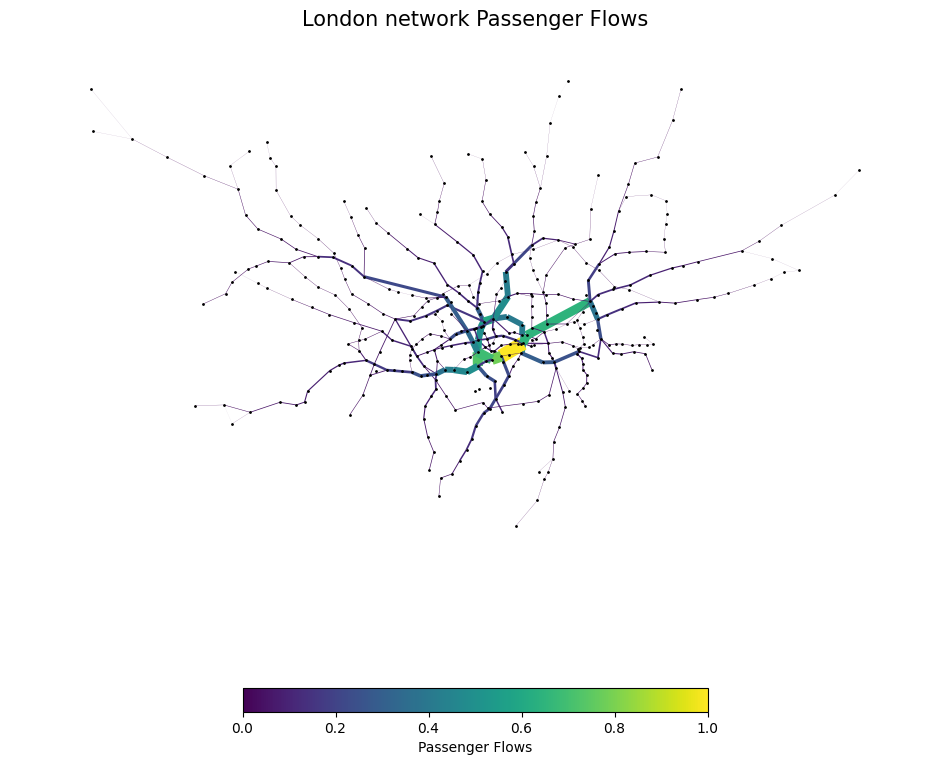

In [40]:
# plot the flows
flows_values = flows.values()
flow_color=[(i[2]['Flow_Sum']/max(flows_values)) for i in G_lu.edges(data=True)]
flow_width=[(i[2]['Flow_Sum']/max(flows_values)*10) for i in G_lu.edges(data=True)]

# plot graph
fig, ax = plt.subplots(figsize=(12,10))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G_lu, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G_lu,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [41]:
# get edge with highest number of flows
max(flows, key=flows.get)

('Bank and Monument', 'Waterloo')

In [42]:
deg_london_w = dict(G_lu.degree(weight='Flow_Sum'))

nx.set_node_attributes(G_lu,deg_london_w,'degree_w')

max_node_d = max(deg_london_w, key=deg_london_w.get)

print(f"The node with the highest degree centrality is: {max_node_d}, with a value of: {deg_london_w[max_node_d]}")

The node with the highest degree centrality is: Bank and Monument, with a value of: 2685403


In [43]:
bet_london_w=nx.betweenness_centrality(G_lu,weight='Flow_Sum',normalized=False)

nx.set_node_attributes(G_lu,bet_london_w,'betweenness_w')

max_node_b = max(bet_london_w, key=bet_london_w.get)

print(f"The node with the highest betweenness centrality is: {max_node_b}, with a value of: {bet_london_w[max_node_b]}")

The node with the highest betweenness centrality is: West Hampstead, with a value of: 31133.25


In [44]:
clos_london_w=nx.closeness_centrality(G_lu, distance='Flow_Sum')

nx.set_node_attributes(G_lu,clos_london_w,'closeness_w')

max_node_c = max(clos_london_w, key=clos_london_w.get)

print(f"The node with the highest closeness centrality is: {max_node_c}, with a value of: {clos_london_w[max_node_c]}")

The node with the highest closeness centrality is: West Hampstead, with a value of: 1.5774576506254367e-06


In [45]:
# create Origin Destination matrix
OD = pd.pivot_table(london_OD_sum, 
                    values ="Flow_Sum", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)

C:\Users\wbwha\AppData\Local\Temp\ipykernel_20712\4003550668.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(london_OD_sum,
C:\Users\wbwha\AppData\Local\Temp\ipykernel_20712\4003550668.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(london_OD_sum,
C:\Users\wbwha\AppData\Local\Temp\ipykernel_20712\4003550668.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD = pd.pivot_table(l

In [46]:
# get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

In [47]:
# add this data as population
london_OD_sum['population'] = london_OD_sum.station_origin.apply(lambda x: origin[x])

In [48]:
london_OD_sum.sort_values('Flow_Sum',ascending=False).head(10)

,station_origin,station_destination,mode,Flow_Sum,population
2837,Bank and Monument,Waterloo,LU,25031,185560
55995,Waterloo,Bank and Monument,LU,22897,157642
39164,Oxford Circus,Victoria,LU,14212,114051
54871,Victoria,Oxford Circus,LU,13442,137095
56020,Waterloo,Canary Wharf,LU,11735,157642
50141,Stratford,Liverpool Street,EZLLU,11017,218574
32687,London Bridge,Canary Wharf,LU,9945,124229
9088,Canary Wharf,Waterloo,LU,9790,109297
30048,King's Cross St. Pancras,Victoria,LU,8909,136921
2601,Bank and Monument,Canary Wharf,DLRLU,8797,185560


In [49]:
Flow_affected = london_OD_sum.loc[london_OD_sum['station_origin'] == 'Bank and Monument', 'Flow_Sum'].sum()

print(f"Number of people affected: {Flow_affected}")

Number of people affected: 185560


In [50]:
G_lu.nodes['Bank and Monument']['coords']

(532819.316945356, 180978.77977526558)

In [51]:
from pyproj import Transformer

# create a coordinate transformer from EPSG:27700 (British National Grid) to EPSG:4326 (WGS 84 - latitude/longitude)
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)

# iterate through each node in the graph
for node in G_lu.nodes:
    # extract x and y coordinates from node attributes
    x, y = G_lu.nodes[node]['coords']
    
    # convert coordinates to longitude and latitude
    lon, lat = transformer.transform(x, y)
    
    # update node attributes with transformed coordinates
    G_lu.nodes[node]['coords'] = (lon, lat)

In [52]:
from geopy.distance import geodesic

# get coordinates of the closed origin station
origin_name = 'Bank and Monument'
lon1, lat1 = G_lu.nodes[origin_name]['coords']
origin_coords = (lat1, lon1)  # geopy uses (lat, lon)

# download pedestrian road network
G_walk = ox.graph_from_point(origin_coords, dist=1000, network_type='walk')

# get nearest node in road network for origin station
origin_node = ox.distance.nearest_nodes(G_walk, lon1, lat1)

# create list of candidate alternative stations
alt_stations = {
    node: data['coords'] for node, data in G_lu.nodes(data=True) if node != origin_name
}

# initialize a list to store results
results = []

# filter by straight-line distance, then compute walking time
for name, (lon2, lat2) in alt_stations.items():
    dest_coords = (lat2, lon2)
    
    crow_distance = geodesic(origin_coords, dest_coords).meters
    if crow_distance > 1000:
        continue

    try:
        dest_node = ox.distance.nearest_nodes(G_walk, lon2, lat2)
        path_length = nx.shortest_path_length(G_walk, origin_node, dest_node, weight='length')
        walk_time_min = path_length / 72  # walking speed:  1.2m/s (72m/min)

        # append result as a dictionary
        results.append({
            'Station': name,
            'PathLength_m': round(path_length),
            'WalkTime_min': round(walk_time_min, 1)
        })

    except Exception as e:
        # log error if needed
        continue

# convert list to DataFrame
df_walk_alternatives = pd.DataFrame(results)

# sort by walking time
df_walk_alternatives = df_walk_alternatives.sort_values(by='WalkTime_min')

# display the DataFrame
print(df_walk_alternatives)

            Station  PathLength_m  WalkTime_min
6     Cannon Street           405           5.6
5     Mansion House           579           8.0
0          Moorgate           818          11.4
7        Tower Hill           840          11.7
8        St. Paul's           856          11.9
1     London Bridge           910          12.6
2           Aldgate           961          13.3
3  Liverpool Street           971          13.5
4     Tower Gateway          1141          15.8


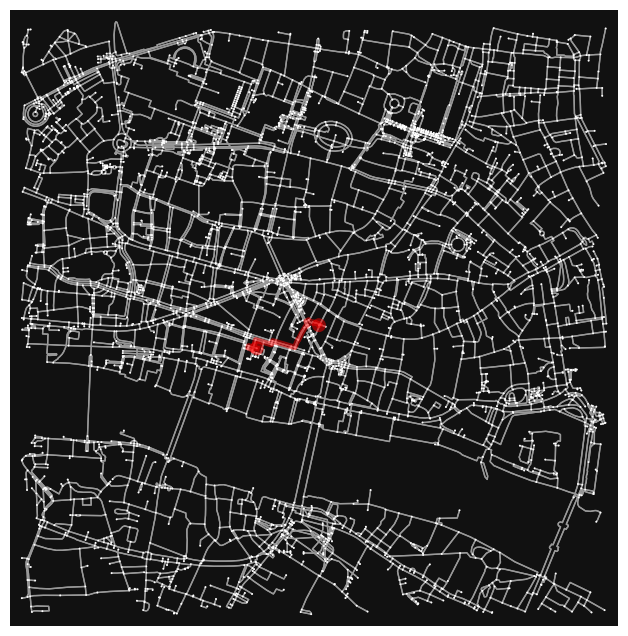

C:\Users\wbwha\AppData\Local\Temp\ipykernel_20712\3656178527.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


In [53]:
# get the station with shortest walk time
best_station = df_walk_alternatives.iloc[0]['Station']
lon_best, lat_best = G_lu.nodes[best_station]['coords']

# find nearest nodes in walking network
dest_node = ox.distance.nearest_nodes(G_walk, lon_best, lat_best)

# reuse origin node
origin_node = ox.distance.nearest_nodes(G_walk, lon1, lat1)

# get shortest path
route = nx.shortest_path(G_walk, origin_node, dest_node, weight='length')

# plot the route
fig, ax = ox.plot_graph_route(G_walk, route, node_size=2)

ax.legend()

plt.show()